In [1]:
import cv2
import torch
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt




In [2]:
path_dir = '/Users/lukassanner/Documents/ZeissHackathon/photomask_trainingdata'

dirs = os.listdir(path_dir)[1:]

data = {}

for d in dirs:
    folder_dir = os.path.join(path_dir,d)
    files = os.listdir(folder_dir)

    tifs = []
    for f in files:
        if f.endswith('.tif'):
            tifs.append(os.path.join(folder_dir, f))
    data[d] = tifs


In [3]:
complete_data_fn = []
complete_data_labels = []
for k,key in enumerate(data.keys()):
    print(f"{key}: {len(data[key])}")
    complete_data_fn += data[key]
    complete_data_labels = np.append(complete_data_labels, (k*np.ones(len(data[key]), dtype=int)).astype(np.int))


COMPLETE FEATURE: 76
BORDERTOUCHER: 22
NO FEATURE: 13


In [4]:
label_map = {}
def label_map(index):
    index = int(index)
    if index == 0:
        return 'COMPLETE FEATURE'
    elif index == 1:
        return 'BORDERTOUCHER'
    elif index == 2:
        return 'NO FEATURE'
    else:
        return 'unkown'


In [5]:
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

class Photomask(Dataset):
        def __init__(self,
                    image_files,
                    label):
            self.image_files = image_files
            self.label = label
        def get_image(self, index):
            fn = self.image_files[index]
            return np.array(Image.open(fn))
            
        def __getitem__(self, index=-1):
            if index == -1:
                index = np.random.randint(self.__len__())
            return self.get_image(index), self.label[index]
    
        def __len__(self):
            return len(self.image_files)

In [6]:
def denoise(image, h = 7, block_size = 7, search_window = 21):
    return cv2.fastNlMeansDenoising(im,None,h,block_size,search_window)


In [7]:
def draw_ellipse(image, ellipses, thickness = 2, color = (255,0,0)):
    out = image.copy()
    for ell in ellipses:
        cv2.ellipse(out, ell, color, thickness)
    return out
        
def find_ellipse(image, binary_threshold = 100, contour_length=5, min_area=10, circ = 0.5):
    (t, segmentation) = cv2.threshold(image, binary_threshold, 255, cv2.THRESH_BINARY)
    contours = find_contours(segmentation)
    ellipses = []
    pi_4 = np.pi * 4
    ellipses_contour = image.copy()
    for i, contour in enumerate(contours):
        if len(contour) >= contour_length:
            area = cv2.contourArea(contour)
            if area >= min_area:  # skip ellipses smaller then 10x10

                arclen = cv2.arcLength(contour, True)
                circularity = (pi_4 * area) / (arclen * arclen)
                if circularity >= circ:
                    ellipses.append(ellipses_of_contour(contour))

    return ellipses

def find_contours(segmentation):
    _, contours, _ = cv2.findContours(segmentation, cv2.RETR_LIST, cv2.CHAIN_APPROX_TC89_L1)
    return contours

def ellipses_of_contour(contour):
    return cv2.fitEllipse(contour)
    
def attributes_of_ellipses(ellipses):
    center = ellipses[0]
    axis = ellipses[1]
    angle = ellipses[2]
    area = np.pi * axis[0] * axis[1]
    return center, axis, angle, area
    

In [47]:
def fft_mag(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    return 20*np.log(np.abs(fshift))

std: normal 35.91146843607135, denoised 22.83805790173598


Text(0.5, 1.0, 'with ellipses')

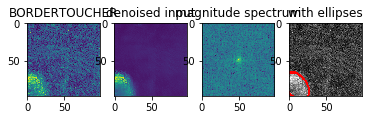

In [103]:
ds = Photomask(complete_data_fn, complete_data_labels)

im, label = ds.__getitem__()

h = 20
block_size = 10
search_window = 50

binary_threshold = 100
contour_length=5 
min_area=20
circ = 0.2

denoised = denoise(im, h=h, block_size=block_size, search_window=search_window)
print(f"std: normal {np.std(im)}, denoised {np.std(denoised)}")

ellipses = find_ellipse(denoised, binary_threshold=binary_threshold, contour_length=contour_length, min_area=min_area, circ=circ)
im_w_ell = draw_ellipse(cv2.cvtColor(im, cv2.COLOR_GRAY2RGB), ellipses, 2, (255,0,0))

f = np.fft.fft2(im)
fshift = np.fft.fftshift(f)

magnitude_spectrum = 20*np.log(np.abs(fshift))

fig, axs = plt.subplots(1,4)
axs[0].imshow(im)
axs[0].set_title(label_map(label))

axs[1].imshow(denoised)
axs[1].set_title('denoised input')

axs[2].imshow(magnitude_spectrum)
axs[2].set_title('magnitude spectrum')

axs[3].imshow(im_w_ell)
axs[3].set_title('with ellipses')

In [17]:
def is_border_toucher(image, ellipses):
    return 0

In [290]:
def predict(image):
    h = 10
    block_size = 5
    search_window = 100

    binary_threshold = 75
    contour_length=5 
    min_area=20
    circ = 0.2

    denoised = denoise(im, h=h, block_size=block_size, search_window=search_window)
    
    diff_mean = np.abs(np.mean(image) - np.mean(denoised))
    diff_var = np.abs(np.var(image) - np.var(denoised))
    print(diff_var, diff_mean)
    if diff_var > 50:
        if diff_mean < 0.37 or diff_var < 900:
            ellipses = find_ellipse(denoised, binary_threshold=binary_threshold, contour_length=contour_length, min_area=min_area, circ=circ)
            state = is_border_toucher(image, ellipses)
            return state, ellipses
    return 2, None

2.7629903086808554 0.05662132001276632


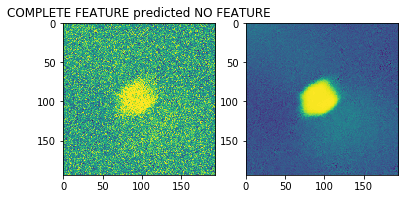

In [292]:

im, label = ds.__getitem__()
state, ellipses = predict(im)
out = im.copy()
if ellipses is not None:
    print([p for p in ellipses])
    im = draw_ellipse(cv2.cvtColor(im, cv2.COLOR_GRAY2RGB), ellipses, 2, (255,0,0))
fig, axs = plt.subplots(1,2)
axs[0].imshow(im)
axs[0].set_title(label_map(label) + " predicted " + label_map(state))
binary_threshold = 100
contour_length=5 
min_area=20
circ = 0.2

denoised = denoise(out, h=h, block_size=block_size, search_window=search_window)

axs[1].imshow(denoised)

In [261]:
np.std(denoised)

49.40248073403462

In [190]:
labels = []
d_std =[]
n_std = []

mag_mean = []
mag_var = []

noise_mean = []
noise_var = []

normal_mean = []
normal_var = []

for k in range(ds.__len__()):
    im, label = ds.__getitem__(k)
    denoised = denoise(im, h=h, block_size=block_size, search_window=search_window)
    mag = fft_mag(denoised)
    
    mag_mean.append(np.mean(mag))
    mag_var.append(np.var(mag))
    
    noise_mean.append(np.mean(denoised))
    noise_var.append(np.var(denoised))
    
    normal_mean.append(np.mean(im))
    normal_var.append(np.var(im))
    labels.append(label)

    


/Users/lukassanner/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/Users/lukassanner/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [191]:
mag_var = np.array(mag_var)
mag_mean = np.array(mag_mean)

noise_mean = np.array(noise_mean)
noise_var = np.array(noise_var)

normal_mean = np.array(normal_mean)
normal_var = np.array(normal_var)

In [192]:
indexes = []
for k in range(3):
    indexes.append(np.array([i for i, e in enumerate(labels) if e == k]))


Text(0.5, 1.0, 'fft magnitude')

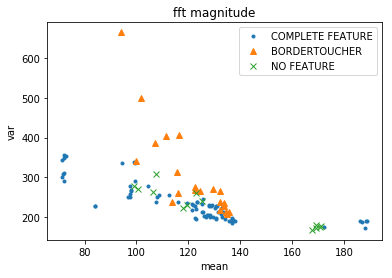

In [194]:
fig, ax = plt.subplots()
signs = ['.', '^', 'x']
for k in range(3):
    ax.plot(mag_mean[indexes[k]], mag_var[indexes[k]], signs[k], label=label_map(k))
ax.set_xlabel('mean')
ax.set_ylabel('var')
ax.legend()
ax.set_title('fft magnitude')

Text(0.5, 1.0, 'denoised')

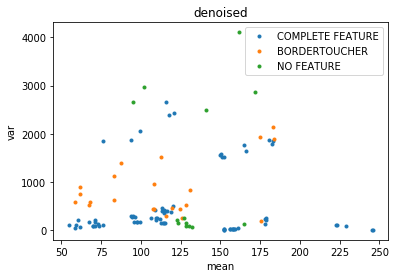

In [92]:
fig, ax = plt.subplots()

for k in range(3):
    ax.plot(noise_mean[indexes[k]], noise_var[indexes[k]], '.', label=label_map(k))
ax.set_xlabel('mean')
ax.set_ylabel('var')
ax.legend()
ax.set_title('denoised')

Text(0.5, 1.0, 'normal')

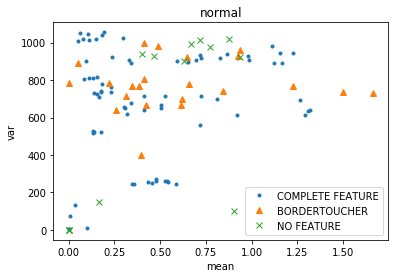

In [196]:
fig, ax = plt.subplots()

for k in range(3):
    ax.plot(np.abs(normal_mean[indexes[k]] - noise_mean[indexes[k]]), np.abs(normal_var[indexes[k]] - noise_var[indexes[k]]), signs[k], label=label_map(k))
ax.set_xlabel('mean')
ax.set_ylabel('var')
ax.legend()
ax.set_title('normal')

In [249]:
mag_std_vals[indexes[1]]

array([13.60838265, 13.37779485, 14.16352034, 13.80614707, 13.82708392,
       13.98296518, 14.338199  , 15.21185903, 15.14723726, 16.06390719,
       13.73713391, 14.70970292, 15.16924086, 13.36356231, 13.35230078,
       13.29184257, 16.27199278, 14.03433033, 15.2357608 , 13.58142206,
       13.43007238,         nan])

21897.014703915032 COMPLETE FEATURE


Text(0.5, 1.0, 'COMPLETE FEATURE')

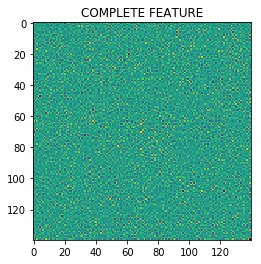

In [250]:
im, label = ds.__getitem__()
#im = denoise(im)
im = cv2.Laplacian(im,cv2.CV_64F)
print(np.var(im), label_map(label))
plt.imshow(im)
plt.title(label_map(label))

In [254]:
can_mean = []
can_var = []

for k in range(ds.__len__()):
    im, label = ds.__getitem__(k)
    denoised = denoise(im, h=h, block_size=block_size, search_window=search_window)
    #mag = fft_mag(im)
    can = cv2.Laplacian(denoised,cv2.CV_64F)
    can_mean.append(np.mean(can))
    can_var.append(np.var(can))
  


In [255]:
can_mean = np.array(can_mean) 
can_var = np.array(can_var)



Text(0.5, 1.0, 'denoised')

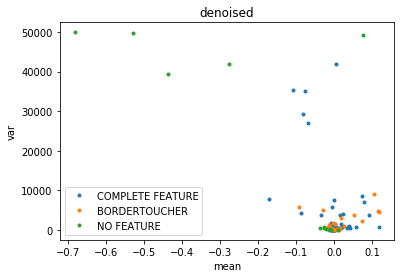

In [256]:

fig, ax = plt.subplots()

for k in range(3):
    ax.plot(can_mean[indexes[k]], can_var[indexes[k]], '.', label=label_map(k))
ax.set_xlabel('mean')
ax.set_ylabel('var')
ax.legend()
ax.set_title('denoised')